In [13]:
import numpy as np
import scipy
from scipy.constants import hbar 
import time
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [3]:
def getExactEigenvalue(m, R, mass):
    return (hbar**2 * m**2) / (2 * mass * R**2)

In [6]:
class ParticleRing:
    
    def __init__(self, h, timingInt):
        self.h = h
        self.timingInt = timingInt
        self.x_max = 10.0
        self.x = np.arange(0, 2*np.pi, h)
        self.kinetic = self.second_derivative_matrix()
        self.position = self.angular_position_matrix()
        
    def xShape(self):
        # This is used for creating the m matrix later on, but doesn't play much of a role in finding the solutions. 
        return self.x, self.x.shape[0]

    def second_derivative_matrix(self):
        # We create the second derivative (kinetic energy) matrix here. 
        N = len(self.x)
        dx = self.x[1] - self.x[0]

        # Generate the matrix for the second derivative using a five-point stencil
        main_diag = np.ones(N) * (-5.0 / 2 / dx**2)
        off_diag = np.ones(N - 1) * 4 / 3 / dx**2
        off_diag2 = np.ones(N - 2) * (-1.0 / (12 * dx**2))

        D2 = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(
            off_diag, k=-1) + np.diag(off_diag2, k=2) + np.diag(off_diag2, k=-2)

        return D2

    def angular_position_matrix(self):
        return np.diag(self.x)
    
    def creator(self, R):
        return - (hbar**2) / (2 * R**2) * self.kinetic + self.position

    def timing(self, H):
        """
        In the timing function, we solve the solution many times and get the average of the times. 
        This helps to boost the accuracy of the time value. The timingInt value determines how many times to collect. 
        """
        solveTime = []
        for i in range(self.timingInt):
            time0 = time.time()
            evals, evects = np.linalg.eigh(H)
            time1 = time.time()
            solveTime.append(time1 - time0)
        avg = sum(solveTime) / len(solveTime)
        return avg

    def solver(self,R):
        # We use the numpy linalg.eigh function to solve for the eigenvalues and eigenvectors of the matrix. 
        H = self.creator(R)
        evals, evects = np.linalg.eigh(H)
        solveTime = self.timing(H)
        evects= evects.T
        m_val = evects[0] / np.linalg.norm(evects[0])*np.sign(evects[0][  int(len(self.x)/2) ])
        return evals, evects, solveTime, m_val


In [9]:
hList = [1/10, 1/20, 1/10]
radii = np.arange(.5,15.5,.5)
timingInt = 10
herrors = []
htimes = []
m = 1
mass = 1.0

for h in hList:
    ParicleRingInstance = ParticleRing(h, timingInt)
    for rad in radii:
        evals, evects, solveTime, m_val = ParicleRingInstance.solver(rad)
        htimes.append(solveTime)
        herrors.append(np.abs(getExactEigenvalue(m,rad,mass)-evals[0]))

In [11]:
h = 10**-1
ParicleRingInstance = ParticleRing(h, timingInt)
x, x_shape = ParicleRingInstance.xShape()
m = np.zeros((len(radii), x_shape))
for rad in radii:
    evals, evects, solveTime, m_val = ParicleRingInstance.solver(rad)
    htimes.append(solveTime)
    herrors.append(np.abs(getExactEigenvalue(m,rad,mass)-evals[0]))

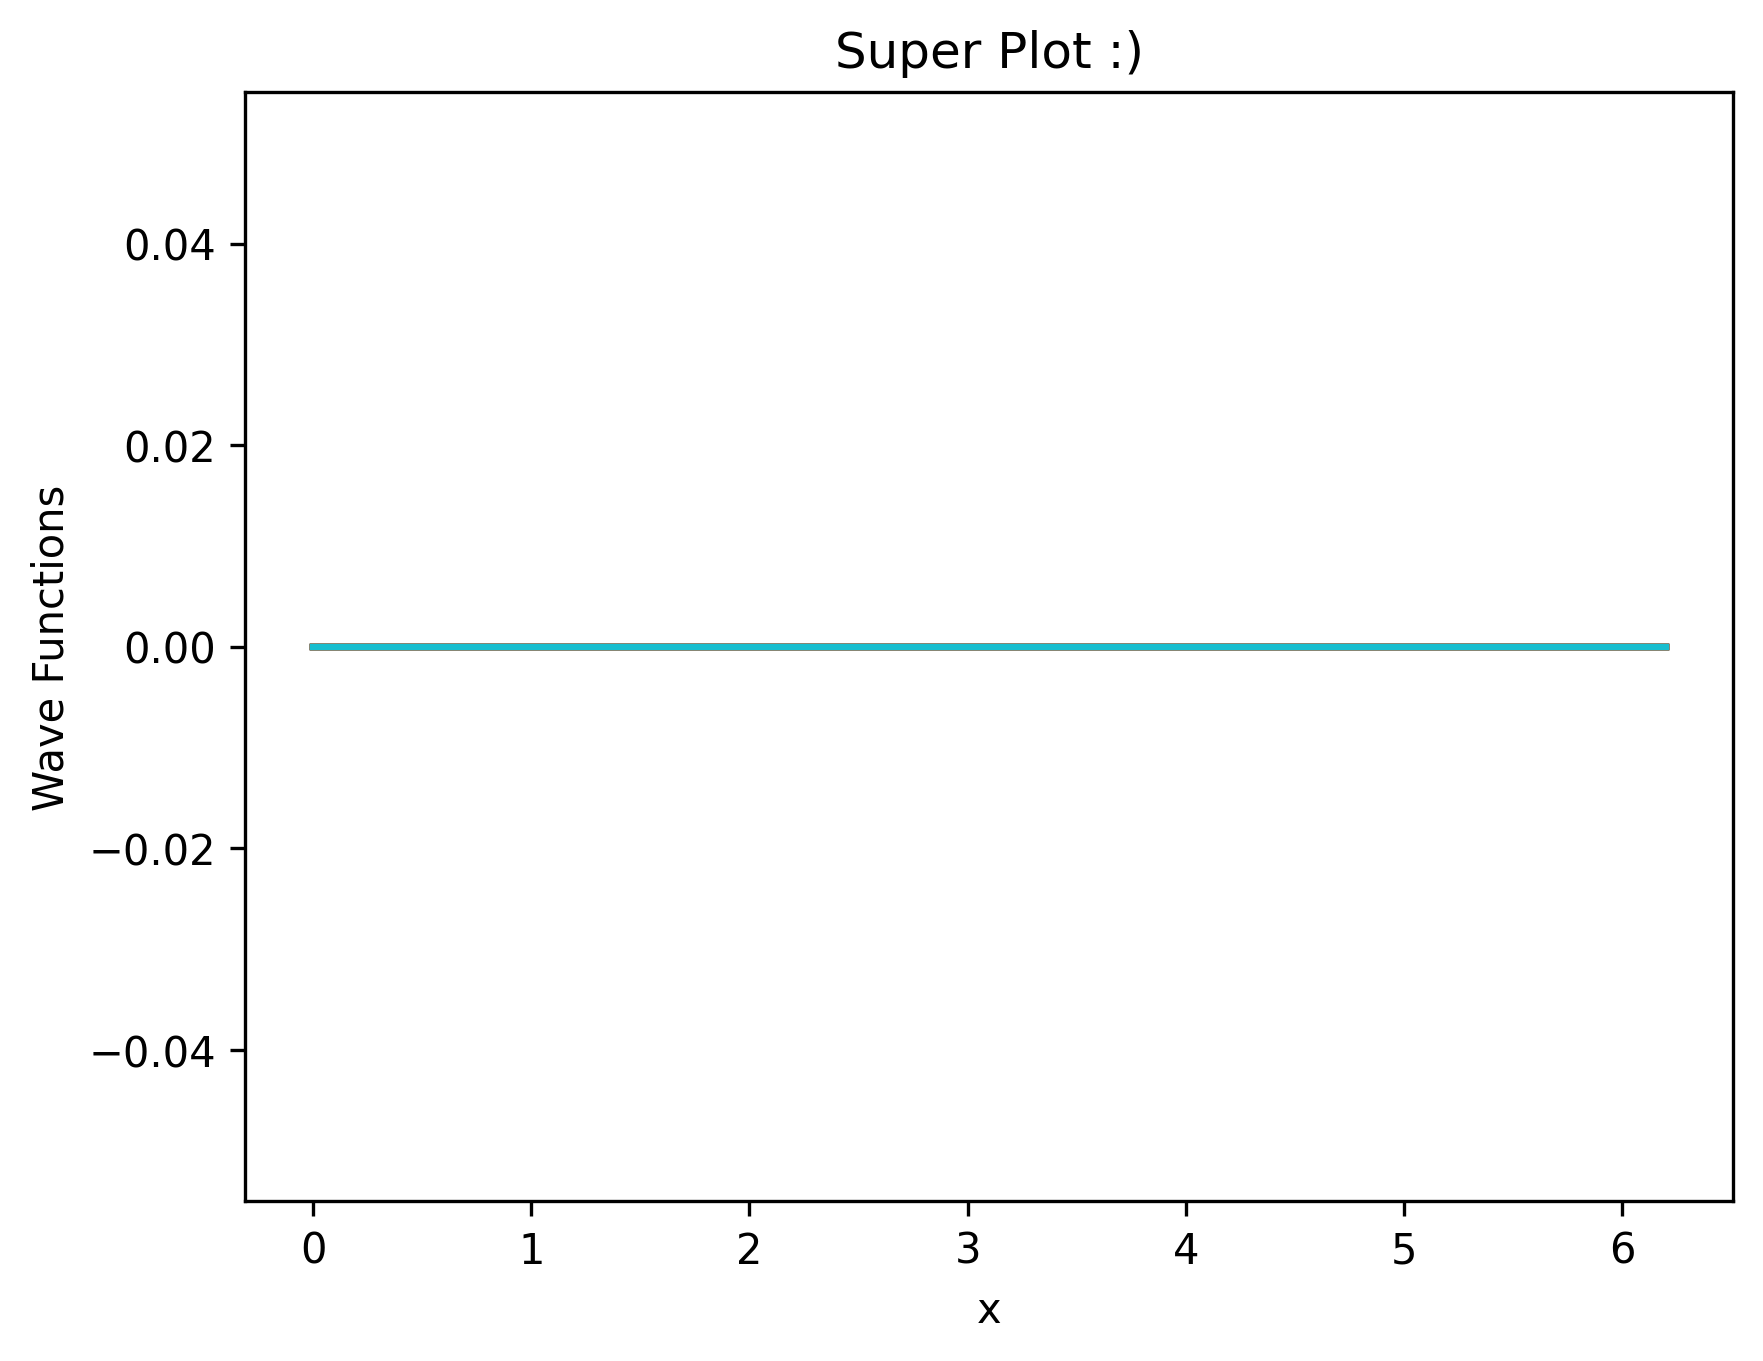

In [14]:
fig, ax = plt.subplots(dpi=300)

for i in range(len(m)):
    ax.plot(x, m[i])

ax.set_title("Super Plot :)")
ax.set_xlabel("x")
ax.set_ylabel("Wave Functions")

plt.show()